In [61]:
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
# Torch package
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [62]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Read Data

In [63]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
df.tail(10)

,Open,High,Low,Close,Volume,Date,EMA_7,EMA_14,EMA_21,SMA_7,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
3248,7711.71,7733.54,7692.48,7728.50,5.750400e+08,2024-02-19,7642.331920,7620.773180,7613.327011,7609.241429,...,5.3288,41.06,-16.79,0.004641,0.000000,0.0,0.0,1.04,-0.01,7728.50
3249,7728.50,7748.73,7705.98,7719.21,8.190300e+08,2024-02-20,7661.551440,7633.898090,7622.952737,7630.188571,...,5.3290,42.75,9.29,0.008685,0.000063,13.4,-11.9,1.58,0.96,7719.21
3250,7719.21,7719.21,7642.75,7662.51,1.190000e+09,2024-02-21,7661.791080,7637.713011,7626.548852,7642.877143,...,5.3270,76.46,56.70,0.003393,-0.000096,5.9,5.9,1.50,-0.47,7662.51
3251,7662.51,7702.86,7651.65,7684.49,1.320000e+09,2024-02-22,7667.465810,7643.949943,7631.816229,7667.478571,...,5.3285,51.21,-21.98,0.009714,0.000080,13.5,13.5,1.63,-0.51,7684.49
3252,7684.49,7713.39,7675.19,7706.28,9.929600e+08,2024-02-23,7677.169357,7652.260617,7638.585663,7687.175714,...,5.3307,38.20,-21.79,0.005206,-0.000225,23.7,-12.6,2.04,1.80,7706.28
3253,7706.28,7710.78,7676.75,7684.30,1.150000e+09,2024-02-26,7678.952018,7656.532535,7642.741512,7699.571429,...,5.3292,34.03,21.98,0.004227,-0.000161,10.6,5.6,2.04,-0.94,7684.30
3254,7684.30,7698.29,7669.71,7683.02,1.060000e+09,2024-02-27,7679.969014,7660.064197,7646.403193,7695.472857,...,5.3300,28.58,1.28,0.003499,0.000000,1.9,1.9,1.64,-1.10,7683.02
3255,7683.02,7693.18,7620.37,7624.98,1.150000e+09,2024-02-28,7666.221760,7655.386304,7644.455630,7680.684286,...,5.3291,72.81,58.04,0.005957,-0.000096,12.2,-3.5,1.68,-0.28,7624.98
3256,7624.98,7677.69,7622.87,7630.02,1.870000e+09,2024-02-29,7657.171320,7652.004130,7643.143300,7667.942857,...,5.3291,54.82,-5.04,0.005302,-0.000113,15.5,-11.4,0.70,0.03,7630.02
3257,7630.02,7695.61,7630.02,7688.38,1.220000e+09,2024-03-01,7664.973490,7656.854246,7647.255727,7671.638571,...,5.3278,65.59,-58.36,0.005503,0.000175,45.1,-43.8,2.54,-1.58,7688.38


In [64]:
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [65]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


## Normalize data

In [66]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [67]:
df.head()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
50,-2.216035,0.076483,-2.142262,-2.152261,-2.194267,-2.125236,-2.076858,-2.136731,0.580627,-0.832570,...,-0.051602,1.239983,0.263215,0.069296,-0.504898,-0.245371,0.621244,0.493902,0.076677,-2.216035
51,-2.056965,-0.239245,-2.123602,-2.142163,-2.184183,-2.111332,-2.077166,-2.125910,0.587184,-0.650028,...,-0.049936,0.645604,-1.592823,0.546749,0.078090,-0.237026,-0.837124,-0.175958,0.061469,-2.056965
52,-2.098709,-0.344334,-2.120115,-2.139050,-2.178879,-2.117365,-2.077906,-2.121902,0.551176,-0.605426,...,-0.049715,0.155241,0.435721,0.581028,6.329870,-1.246710,0.090208,-0.326489,0.989154,-2.098709
53,-2.101239,0.232217,-2.118136,-2.136693,-2.174291,-2.119588,-2.081983,-2.115752,0.513769,-0.573078,...,-0.049288,0.938548,0.039596,0.103050,0.078090,0.572390,-0.203051,-1.432887,0.008242,-2.101239
54,-2.114521,0.606201,-2.119995,-2.136444,-2.171350,-2.119997,-2.105306,-2.108239,0.467045,-0.569404,...,-0.048312,0.724147,0.148211,-0.139122,1.708155,0.405500,0.288356,0.019731,0.152717,-2.114521


## Data processing for time series model

The data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [68]:
sequence_length = 60
window =10

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

In [69]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df))-10
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3208
Train sample 3198
Test sample 10


In [70]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

X_train=torch.FloatTensor(np.array(X_train))
y_train=torch.FloatTensor(np.array(y_train))

print(X_train.shape, y_train.shape)

torch.Size([1564, 60, 29]) torch.Size([1564, 10])


In [71]:
batch_size=10
train_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

In [72]:
# The unknown data
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]
torch.FloatTensor([X_check]).shape

torch.Size([1, 60, 29])

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [73]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Classical LSTM

In [74]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window
        self.linear_2 = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_l1, (hn, _) = self.lstm(x, (h0, c0))
        out_l2 = self.linear(out_l1)
        out = self.linear_2(torch.squeeze(out_l2))
        return torch.squeeze(out)

In [75]:
learning_rate = 0.001
num_hidden_units = 16

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [76]:
lstm_loss_train = []
num_epoch=9
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
#     y_test_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
#     y_test_pred_lstm = y_test_pred_lstm.detach().numpy()
#     print(mean_absolute_error(y_check* target_stdev + target_mean,y_test_pred_lstm* target_stdev + target_mean))
    lstm_loss_train.append(train_loss)

Epoch 0
---------
Train loss: 0.32461231178159167
Epoch 1
---------
Train loss: 0.0911430029471399
Epoch 2
---------
Train loss: 0.06523739194177139
Epoch 3
---------
Train loss: 0.056724350638450334
Epoch 4
---------
Train loss: 0.050649707258981505
Epoch 5
---------
Train loss: 0.04464996370611487
Epoch 6
---------
Train loss: 0.0403856991784303
Epoch 7
---------
Train loss: 0.038430415384566326
Epoch 8
---------
Train loss: 0.03553047048960142


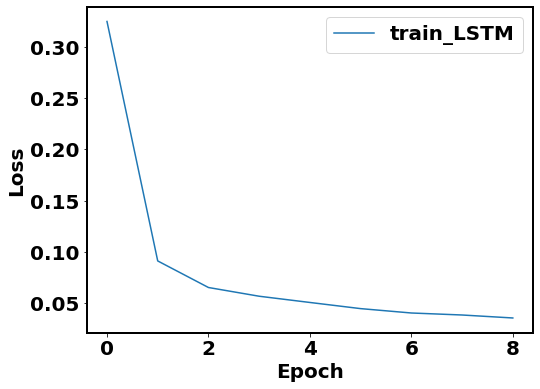

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train_LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [78]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [79]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
    

In [80]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [81]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)


MAE train error is 95.13513309940411
RMSE train error is 123.17871263832043


In [82]:
y_check_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
y_check_pred_lstm = y_check_pred_lstm.detach().numpy()

mae_check_lstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_lstm)

MAE check error  :  35.37421875
RMSE check error :  38.91962945260964


In [83]:
y_check_pred_lstm* target_stdev + target_mean

array([7676.625 , 7726.4346, 7686.6445, 7657.274 , 7640.7373, 7650.3975,
       7644.205 , 7652.706 , 7655.029 , 7636.083 ], dtype=float32)

In [84]:
y_check* target_stdev + target_mean

array([7728.5 , 7719.21, 7662.51, 7684.49, 7706.28, 7684.3 , 7683.02,
       7624.98, 7630.02, 7688.38])

In [85]:
from datetime import datetime, date, timedelta
start='2024-02-19'
start = datetime.strptime(start, '%Y-%m-%d')
end= start + timedelta(days=13)
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(start, end,freq='B').date, columns=['Date'])

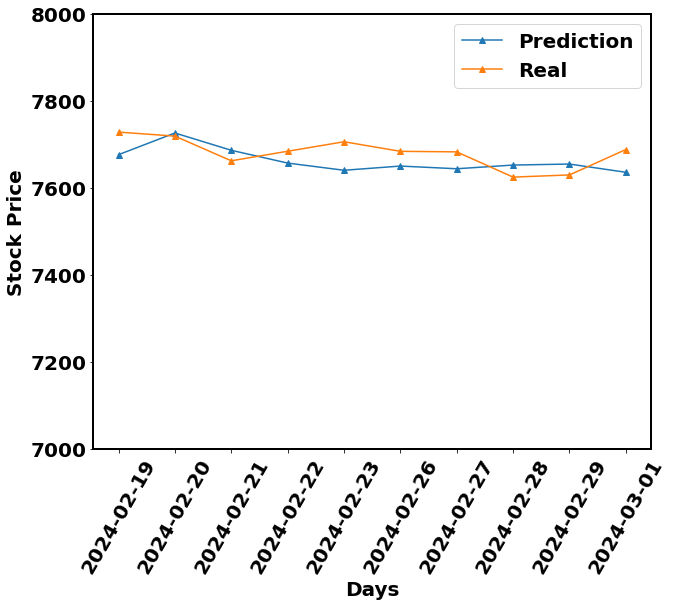

In [86]:
plt.figure(figsize=(10, 8))
plt.plot( y_check_pred_lstm* target_stdev + target_mean, label = "Prediction",marker='^')
plt.plot( y_check* target_stdev + target_mean, label = "Real",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.xticks(list(range(10)), all_dates['Date'].values)
plt.xticks(rotation=60)
plt.ylim(7000, 8000) 
plt.legend()
plt.show()

In [87]:
total_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print("No. of parameters for Classical LSTM: ", total_params)

No. of parameters for Classical LSTM:  5811


# From 1st to 15th march

In [88]:
X_1_15=(df[features].values)[len(df)-sequence_length:len(df)]
torch.FloatTensor([X_1_15]).shape

torch.Size([1, 60, 29])

In [89]:
y_pred_1_15 = model_lstm(torch.FloatTensor([X_1_15]))
y_pred_1_15 = y_pred_1_15.detach().numpy()

In [90]:
y_pred_1_15* target_stdev + target_mean

array([7624.0225, 7624.9414, 7601.688 , 7616.088 , 7592.8345, 7567.1323,
       7574.6562, 7605.6714, 7603.827 , 7583.411 ], dtype=float32)